_TensorFlow 2.0_

_coding: utf-8_

In [4]:
import tensorflow as tf

# MNIST 데이터 다운로드
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# x_train.head()
# AttributeError: 'numpy.ndarray' object has no attribute 'head'
# type(x_train) >> numpy.ndarray

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


numpy.ndarray

In [5]:
# GPU is much faster on float32 라고도 하고 default data type이 float32 tensorflow에서
# 이미지들을 float32 데이터 타입으로 변경
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')

In [7]:
# 28*28 형태의 이미지를 784차원으로 flattening 합니다.
x_train, x_test = x_train.reshape([-1,784]), x_test.reshape([-1,784])
print(x_train.shape)
x_train

(60000, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
# Often, the motivation is to achieve consistency in dynamic range for a set of data, signals, or images to avoid mental distraction or fatigue. 
# In image processing, normalization is a process that changes the range of pixel intensity values.
# [0,255] 사이의 값을 [0,1] 사이의 값으로 Normalize
x_train, x_test = x_train / 255. , x_test / 255. # 소수점 세심한 거 봐

In [10]:
# 레이블 데이터에 one-hot encoding 적용
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

# 학습을 위한 설정값들(param?) 정의
learning_rate = 0.001 # gradient descent(아래)에서의 alpha
num_epochs = 30 # 한 번의 epoch이란 학습데이터 50000개를 한 번 전부 훑는 것
batch_size = 256 # 50000개 중 256개씩 묶어서 하겠다.
display_step = 1 # 손실함수 출력 주기
input_size = 784 # 28*28 input layer의 노드 개수를 설정
hidden1_size = 256
hidden2_size = 256
output_size = 10

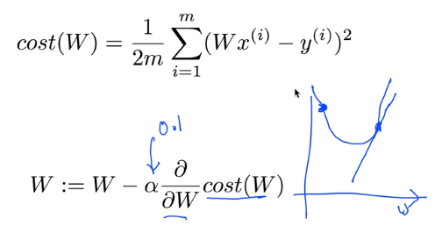

In [13]:
# tf.data API 이용하여 데이터 섞고 batch 형태로 가져온다.
# tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성
# 예를 들어 MNIST의 학습데이터 (60000,28,28)가 입력되면, 60000만개의 slices로 만들고 각각의 slice는 28*28의 이미지 크기를 갖게 된다.
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
# print(train_data.shape)
# AttributeError: 'DatasetV1Adapter' object has no attribute 'shape'
# train_data >> <DatasetV1Adapter shapes: ((784,), (10,)), types: (tf.float32, tf.float32)>
train_data = train_data.shuffle(60000).batch(batch_size) # shuffle은 한 번 epoch이 끝났을 때 보통 해주는 데 필수는 아님. 하지만 해주는 것이 성능이 나은 것으로 알려져 있다.

In [15]:
# tf.keras.initializers.RandomNormal >> Initializer that generates tensors with a normal distribution.
def random_normal_initializer_with_stddev_1():
    return tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0, seed=None)

_케라스에서는 층(layer)을 조합하여 모델(model)을 만듭니다. 모델은 (일반적으로) 층의 그래프입니다. 가장 흔한 모델 구조는 층을 차례대로 쌓은 tf.keras.Sequential 모델입니다._<br /><br />
_**층 설정**_<br />
_tf.keras.layers 아래의 클래스들은 일부 생성자 매개변수를 공통으로 가지고 있습니다:_
+ activation: 층의 활성화 함수를 설정합니다. 이 매개변수에는 기본으로 제공되는 함수의 이름을 쓰거나 호출 가능한 객체를 지정할 수 있습니다. 기본값은 활성화 함수를 적용하지 않는 것입니다.
+ kernel_initializer와 bias_initializer: 층의 가중치(weight)(커널(kernel)과 절편(bias))를 초기화하는 방법입니다. 내장 함수나 호출 가능한 객체를 지정합니다. 기본값은 "glorot_uniform" 초기화입니다.
+ kernel_regularizer와 bias_regularizer: L1 또는 L2 규제(regularization)와 같이 층의 가중치(커널과 절편)에 적용할 규제 방법을 지정합니다. 기본값은 규제를 적용하지 않는 것입니다.

In [17]:
# tf.keras.Model 상속받고 ANN모델 정의
# class 생성 규칙을 잘 숙지하고 있으면 좋다

#  부모 클래스인 Machine_cnn_lenet의 도 움을 받아 클래스 초기화를 진행합니다 
# super and self is similar;
# super() lets you avoid referring to the base class explicitly, which can be nice. But the main advantage comes with multiple inheritance, where all sorts of fun stuff can happen. See the standard docs on super if you haven't already.
# You can see that super is calling the base class (the class that the current class inherits), followed by an access modifier, accessing the base class' .__init__() method. It's like self, but for the base class.
# tf.Variable 보다 tf.keras.layers.Dense 로 하는 게 낫대

class ANN(tf.keras.Model):
    def __init__(self):
        super(ANN, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(hidden1_size,
                                                   activation = 'relu',
                                                   kernel_initializer = random_normal_intializer_with_stddev_1(),
                                                   bias_initializer = random_normal_intializer_with_stddev_1())
        self.hidden_layer_2 = tf.keras.layers.Dense(hidden2_size,
                                                   activation = 'relu',
                                                   kernel_initializer = random_normal_intializer_with_stddev_1(),
                                                   bias_initializer = random_normal_intializer_with_stddev_1())
        self.output_layer = tf.keras.layers.Dense(output_size,
                                                 activation = None,
                                                 kernel_initializer = random_normal_intializer_with_stddev_1(),
                                                 bias_initializer = random_normal_initializer_with_stddev_1())
        
    def call(self, x):
        H1_output = self.hidden_layer_1(x)
        H2_output = self.hidden_layer_2(H1_output)
        logits = self.output_layer(H2_output)
        
        return logits
    
# cross-entropy 손실 함수 정의
# decorator(@) 사용 시, 미리 컴파일을 해서 속도를 빠르게 해준다 단점도 있는데..
@tf.function 
def cross_entropy_loss(logits, y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# 함수 내 logit을 써야 하므로 call 함수는 logits을 return한다

# 최적화를 위한 Adam 옵티마이저를 정의해보면
optimizer = tf.optimizers.Adam(learning_rate)

# 최적화를 위한 function을 정의한다.
# 한 번 파라미터 갱신하게 된다. train_step을 for loop 안에서 한 번 실행할 때 마다
@tf.function 
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = cross_entropy_loss(y_pred,y)
        gradients = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
# 모델의 정확도 출력하는 함수 정의합니다.
# tf.argmax(y,1) >> 1인 이유는 두 번째 차원을 레이블로 사용하기 때문에 1인 것이다.  
@tf.function
def compute_accuracy(y_pred,y):
    correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

AttributeError: module 'tensorflow' has no attribute 'function'

### **그래디언트 테이프**
<br />텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 위한 tf.GradientTape API를 제공합니다. tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 **"기록"** 합니다. 그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.

### **옵티마이져** 

__What are kernel initializers and what is their significance?__

The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.<br />For example in the above code, normal distribution will be used to initialise weights. You can use other functions (constants like 1s or 0s) and distributions (uniform) too. All possible options are documented here.<br /> Additional explanation: The term kernel is a carryover from other classical methods like SVM. The idea is to transform data in a given input space to another space where the transformation is achieved using kernel functions. We can think of neural network layers as non-linear maps doing these transformations, so the term kernels is used.

In [ ]:
# [참고]
# [https://hiseon.me/data-analytics/tensorflow/tensorflow-dataset/]
# https://www.tensorflow.org/guide/keras/overview?hl=ko
# https://github.com/solaris33/deep-learning-tensorflow-book-code 바탕으로 공부공부